# Lab 1: "Quantization and Entropy Coding"

* Student full name:
* Student email:

# 0. Introduction
During this lab, you will work with the concepts seen during the Lectures. The lab is divided into excercises related to the following fundamental concepts:

- Uniform quantization, and quantization error
- Entropy
- Huffman Coding / Decoding

The delivery will consist of a copy of this notebook, with your code, figures, and answers. Please, once finished, run all cells (hopefully without errors) and download your notebook as a `.ipynb` file, which will be submitted to Aula Global.

We recommend to work directly on a Google Colab notebook, since we do not require a powerful server, and everything is already set up. In any case, you can work in your own laptop if you prefer to, by installing all required dependencies.

In [1]:
# Install a few dependencies that are not included by default
!apt-get install -y ffmpeg
!ffmpeg -y -i https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0010_8k.wav -af "volume=9dB" -t 20 -ac 1 -ar 11025 -acodec pcm_s16le speech.wav
!pip install huffman
!pip install bitarray

zsh:1: command not found: apt-get
ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0-with-options_4 --enable-shared --cc=clang --host-cflags= --host-ldflags= --enable-gpl --enable-libaom --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-libsnappy --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-demuxer=dash --enable-opencl --enable-audiotoolbox --enable-videotoolbox --enable-neon --disable-htmlpages
  libavutil      58.  2.100 / 58.  2.100
  libavcodec     60.  3.100 / 60.  3.100
  libavformat    60.  3.100 / 60.  3.100
  libavdevice    60.  1.100 / 60.  1.100
  libavfilter     9.  3.100 /  9.  3.100
  libswscale      7.  1.100 /  7.  1.100
  libswresample   4. 10.100 /  4. 10.100
  libpostproc    57.  1.100 / 57.  1.1

In [2]:
# Check we are using python 3
import sys
assert(sys.version_info.major == 3)

In [3]:
# Some useful functions that will be used along the assignment

import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

def generate_decay_signal(sample_rate=11025, freq=1000, phase=0, duration=20):
    """ Generate a tone modulated by a decay signal

    This signal is useful to study the impact of quantization, since it uses
    the full dynamic range.

    Args:
        sample_rate (int): Sample rate
        freq (float): Tone frequency
        phase (float): Tone phase
        duration (float): Signal duration in seconds

    Returns:
        (np.array) Samples array
    """
    times = np.arange(0, duration, 1/sample_rate)
    cy = np.cos(2 * np.pi * times * freq + phase)
    sy = np.sin(2 * np.pi * times * freq + phase)
    pulse = cy + sy
    unclipped_decay_signal = pulse * 25 * np.exp(-times * 0.5)
    decay_signal = np.minimum(np.maximum(unclipped_decay_signal, -1), 1)
    return decay_signal

def display_spectrogram(x, hop_length=128, n_fft=256, sample_rate=11025):
    """ Display spectrogram of signal x

    Args:
        x (numpy.array): Array of samples
        hop_length (int): Spectrogram hop length
        n_fft (int): Spectrogram fft size
        sample_rate (int): Sample rate
    """
    from librosa.display import specshow
    data = librosa.amplitude_to_db(
        np.abs(librosa.core.stft(x,
                                 hop_length=hop_length,
                                 n_fft=n_fft,
                                 center=True)),
                                 ref=np.max)
    plt.figure(figsize=(10, 5))
    specshow(data, x_axis='time', y_axis='linear', cmap='inferno',
            sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')

def display_audio_player(x, sample_rate=11025):
    """ Display an embedded audio player

    Args:
        x (numpy.array): Array of samples
        sample_rate (int): Sample rate
    """
    return Audio(x, rate=sample_rate)

# 1. Quantization (40%)

## Exercise 1.1 (10%)

**a) Write a function to plot the waveform of an audio signal (add documentation as in `display_spectrogram`, use `matplotlib`, add at least axis names, make it nice)**

In [4]:
def plotAudio(x, sr):
    """ Displays an audio signal.

    Args:
        x (numpy.array): Array of samples
        sr (int): Sample Rate
    """

    tt = np.arange(0, len(x)/sr, 1/sr)
    plt.figure(figsize=(10, 4))
    plt.xlabel("[t]")
    plt.ylabel("A[t]")
    plt.title("Audio Signal")
    plt.plot(tt, x)


**b) Plot the waveform of the signal generated with `generate_decay_signal()`**

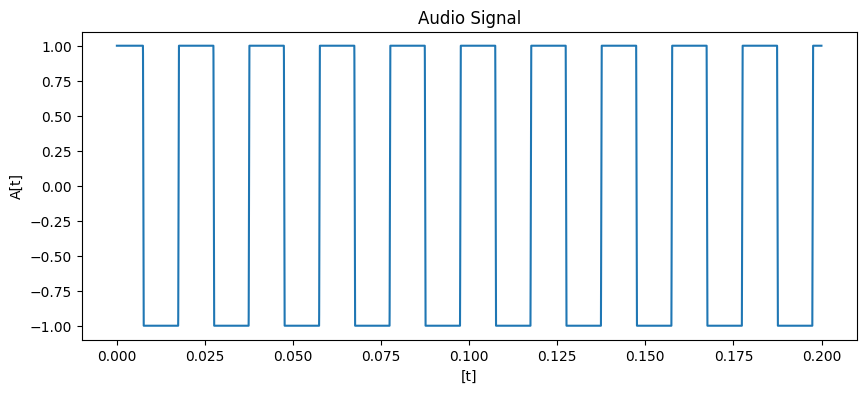

In [5]:
sr  = 44100
f   = 50
dur = (1/f) * 10  

x = generate_decay_signal(sample_rate = sr, freq = f, duration = dur)
plotAudio(sr=sr, x=x)


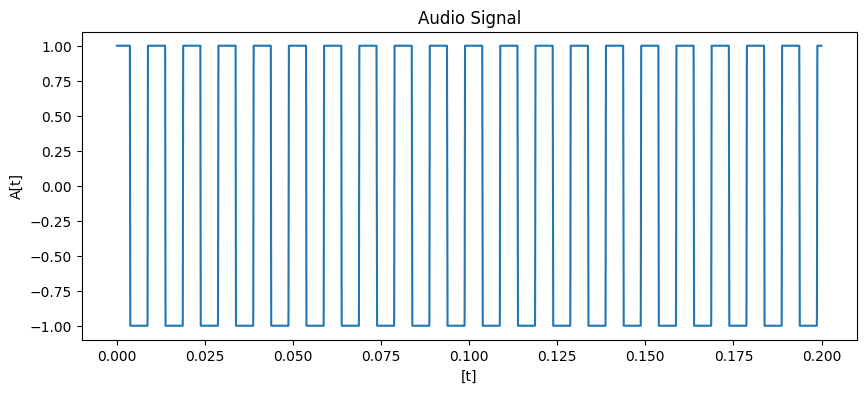

In [6]:
f   = 100 
x = generate_decay_signal(sample_rate = sr, freq = f, duration = dur)
plotAudio(sr=sr, x=x)

**c) Embed an audio player in order to listen to the signal**

In [7]:
f   = 200
dur = 20
x = generate_decay_signal(sample_rate = sr, freq = f, duration = dur)
Audio(data = x, rate = sr)

**d) Display the spectrogram using `display_spectrogram` function**

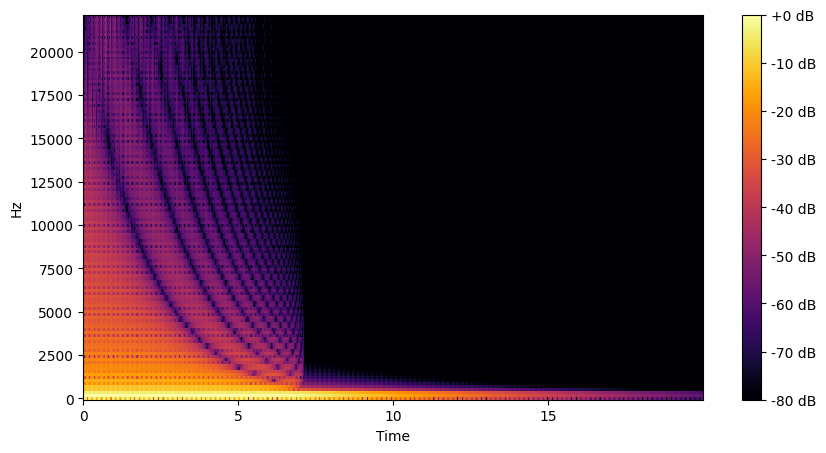

In [8]:
display_spectrogram(x = x, sample_rate = sr)

**e) Observe the waveform, the spectrogram, and listen to the audio. Describe briefly your observations**

As the function name suggests, the signal is a decaying signal, in this case a modulated square wave, which can be determined audibly due to its sharp synth-like character, its shape and the fact that all frequencies are present in the spectrogram. We can also see and hear the impact of the modulation by the chirp-like downward sweeps. Over time the signal decays, which is convenient for testing different quantisation methods.

## Exercise 1.2 (25%)

Before describing the task, we present an explanation that might help to better understand the approach of the exercise.

### About symmetrical mid-rise vs. asymmetrical mid-tread

In the bibliography suggested:

*Introduction to Digital Audio Coding and Standards. Authors: Bosi, Marina and Goldberg, Richard E.*
http://last.hit.bme.hu/download/vidtechlab/fcc/literature/audio/audio_coding_standards_book.pdf

The following claim is made:

*We typically choose quantizers that are symmetric in that there are an equal number of levels (codes) for positive and negative numbers.*

However, in the case of standard PCM audio codings, this is not the case. For instance, 16 bits PCM WAV coding (16 bits signed integers) assigns `-32768` to $-1.0$ amplitude value, `0` to $0.0$ amplitude value, and `+32767` to $+1.0 - \frac{1}{2^{15}}$ amplitude value. The amplitude value $1.0$ has no representation in 16 bits PCM WAV audio files.

In [9]:
# Some code to illustrate the previous explanation.

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
from scipy.io.wavfile import write
from scipy.io.wavfile import read

x = np.array([-32768, -1, 0, 1, 32767], dtype=np.int16)
write('codec__pcm_s16le.wav', 8000, x)
sr, y = read('codec__pcm_s16le.wav')

In [10]:
!ffprobe  -v error -i codec__pcm_s16le.wav -show_entries stream=codec_name

[STREAM]
codec_name=pcm_s16le
[/STREAM]


In [11]:
# Convert to float 32 bits codec
!ffmpeg -y -v error -i codec__pcm_s16le.wav -acodec pcm_f32le codec__pcm_f32le.wav

In [12]:
sr, z = read('codec__pcm_f32le.wav')
for sample in z:
    print(sample)

-1.0
-3.0517578e-05
0.0
3.0517578e-05
0.9999695




---

**a) The following function "simulates" the quantization of a signal using an asymmetric uniform mid-tread quantizer with N bits. Please, explain how the function works, and why each line is needed. Imagine you select N=2: does it mean this python program is using 2 bits to store internally each of the numbers produced by this `quantize(x, N)` python function? (you can check it with https://numpy.org/doc/stable/reference/generated/numpy.ndarray.nbytes.html). Why do we say this function "simulates" the quantization process?**

```python
def quantize(x, N):
    """ Quantize signal using N bits
    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    x = np.array(x)
    quantized = np.round(x * 2**(N-1))
    quantized = np.minimum(quantized, 2**(N-1) - 1)
    quantized = np.maximum(quantized, -2**(N - 1))
    quantized = quantized.astype(np.int16)
    return quantized.reshape(x.shape)
```

**Remember this mid-tread quantization function:**

![](https://vru.vibrationresearch.com/wp-content/uploads/2019/10/quantization_midtread_8bit.png-1.png)

#### **Q:Why do we say this function "simulates" the quantization process?**

We can essentially think of quantisation as a sort of mapping, in which the continuous dynamic range of an audio signal (or any signal, really) is discretized into finite range. The mapping process involves assigning each individual sample of the signal to the nearest value or level that is representable, determined by the quantisation step $\Delta$.

In the python code provided above, we see that, after converting the input signal to a numpy array, we first scale/map the values of $x$ to our N-Bit quantisation range and then round the result to the nearest integer, thereby "simulating" what a quantizer would do during or after AD-conversion.

During this process, values above or below the range of numbers that can be represented by N bits are clipped, thus the min and max functions to simulate this effect.

Finally, the quantized array is converted to be represented by 16 bit integers, a bit depth that is standard in audio CDs. **** 


#### **Q: Imagine you select N=2: does it mean this python program is using 2 bits to store internally each of the numbers produced by this `quantize(x, N)` python function?**

In [13]:
x = np.array([0, -6, 5, -3, 22, -72])
N = 3

quantized = np.round(x * 2**(N-1))
quantized = np.minimum(quantized, 2**(N-1) - 1)
quantized = np.maximum(quantized, -2**(N - 1))
quantized = quantized.astype(np.int16)
quantized.reshape(x.shape)
print(quantized)

[ 0 -4  3 -4  3 -4]


If we choose $N = 2$ this means that we have a total of $2^2 = 4$ possible quantization values, encoded for instance as:
<br>
<br>
$
00 \\
01 \\
10 \\
11
$
<br>
<br>
Python doesn't actually use 2 bits internally to represent the numbers in the array *quantized*. Recall that we are merely simulating the quantization process and that, in fact, the numbers are represented as 16 bit integers once the function has been executed (4th line). However, it simulates only having a 2 bit resolution by creating the relationship explained earlier, that is, remapping the input values to the $2^N - 1$ range and clipping values above or below what can be represented within this range. 

In [14]:
def quantize(x, N):
    """ Quantize signal using N bits
    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    x = np.array(x)
    quantized = np.round(x * 2**(N-1))
    quantized = np.minimum(quantized, 2**(N-1) - 1)
    quantized = np.maximum(quantized, -2**(N - 1))
    quantized = quantized.astype(np.int16)
    return quantized.reshape(x.shape)

**A set of tests are provided to check if your function is correctly implemented or not:**

x: -1.5, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -1.0, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -0.88, code: -4, dequant: -1.0, expected code: -4, expected dequant: -1.0
x: -0.86, code: -3, dequant: -0.75, expected code: -3, expected dequant: -0.75
x: -0.126, code: -1, dequant: -0.25, expected code: -1, expected dequant: -0.25
x: -0.125, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0.125, code: 0, dequant: 0.0, expected code: 0, expected dequant: 0.0
x: 0.126, code: 1, dequant: 0.25, expected code: 1, expected dequant: 0.25
x: 1.0, code: 3, dequant: 0.75, expected code: 3, expected dequant: 0.75
x: 1.5, code: 3, dequant: 0.75, expected code: 3, expected dequant: 0.75


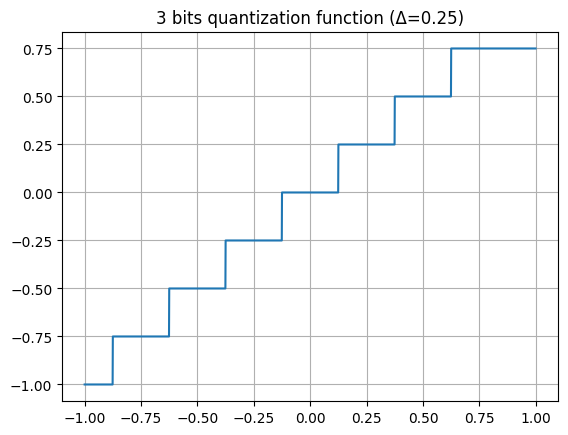

In [15]:
# Run this cell for automatic testing

def dequantize(codes, N):
    """ Dequantize signal using N bits

    Args:
        x (numpy.array): Array of samples
        N (int): Number of bits
    """
    return np.array(codes) / 2**(N - 1)

# Test
test_vector = [-1.5,
               -1.0,
               -0.88,
               -0.86,
               -0.126,
               -0.125,
               0,
               0.125,
               0.126,
               1.0,
               1.5]
expected_codes = [-4, -4, -4, -3, -1, 0, 0, 0, 1, 3, 3]
expected_dequantized = [-1.0,
                        -1.0,
                        -1.0,
                        -0.75,
                        -0.25,
                        0.0,
                        0.0,
                        0.0,
                        0.25,
                        0.75,
                        0.75]
codes = quantize(test_vector, 3)
dequantized = dequantize(codes, 3)

for x, y, z, e_y, e_z in zip(test_vector, codes, dequantized,
                             expected_codes, expected_dequantized):
    print("x: {0}, code: {1}, dequant: {2}, expected code: {3}, expected dequant: {4}".format(x, y, z, e_y, e_z))
    assert(y == e_y)
    assert(z == e_z)

# Quantization function using 3 bits
plt.figure()
x = np.arange(-1.0, 1.0, 0.001)
y = dequantize(quantize(x, 3), 3)
plt.plot(x, y)
plt.grid()
plt.title('3 bits quantization function (Δ=0.25)')
plt.show()

**b) Complete the function `get_snr(N)` to compute the SNR in dBs given a number of bits for a signal with uniform distribution.**

**Note that we added a hack (adding or subtracting $\frac{1}{2^N}$) in order to use a mid-rise quantizer because the formula $SNR = N \times 6.021$ is valid for a symmetric quantizer with $2^N$ steps.**

Here, please remember that the SNR in dBs is given by:

snr = 10 * np.log10(energy_x / energy_qn)

Where energy_x is the energy of signal x, and energy_qn is the energy of the quantization error (i.e. x-y).

Do not forget to return the snr at the end of the function.

In [16]:
def compute_energy(x):
    return np.sum(x**2)

def get_snr_uniform(N):
    x = np.random.uniform(low=-1.0, high=1.0, size=(1000000,))
    y = dequantize(quantize(x - (1/2**N), N), N) + 1/2**N  # for this experiment
                                                           # we use a mid-rise quantizer
                                                           # (symmetry reasons)
    # Complete this function:
    energy_x    = compute_energy(x)
    energy_qn   = compute_energy(x - y)
    assert(energy_qn != 0)           # ensuring that denom is not zero
    epsilon = np.finfo("float").eps           # handling log
    return 10 * np.log10((energy_x + epsilon) / energy_qn)

def get_theoretical_snr_uniform(N):
    theo_snr = N * 6.021
    return theo_snr


N_range = range(1, 16)
snrs = [get_snr_uniform(N) for N in N_range]
theo_snrs = [get_theoretical_snr_uniform(N) for N in N_range]
for (N, snr, theo_snr) in zip(N_range, snrs, theo_snrs):
    print("N:{0} bits - SNR:{1:.2f}dB - Theoretical SNR:{2:.2f}dB".format(N, snr, theo_snr))

N:1 bits - SNR:6.02dB - Theoretical SNR:6.02dB
N:2 bits - SNR:12.04dB - Theoretical SNR:12.04dB
N:3 bits - SNR:18.06dB - Theoretical SNR:18.06dB
N:4 bits - SNR:24.08dB - Theoretical SNR:24.08dB
N:5 bits - SNR:30.11dB - Theoretical SNR:30.11dB
N:6 bits - SNR:36.13dB - Theoretical SNR:36.13dB
N:7 bits - SNR:42.15dB - Theoretical SNR:42.15dB
N:8 bits - SNR:48.16dB - Theoretical SNR:48.17dB
N:9 bits - SNR:54.18dB - Theoretical SNR:54.19dB
N:10 bits - SNR:60.21dB - Theoretical SNR:60.21dB
N:11 bits - SNR:66.22dB - Theoretical SNR:66.23dB
N:12 bits - SNR:72.24dB - Theoretical SNR:72.25dB
N:13 bits - SNR:78.26dB - Theoretical SNR:78.27dB
N:14 bits - SNR:84.27dB - Theoretical SNR:84.29dB
N:15 bits - SNR:90.31dB - Theoretical SNR:90.31dB


## Exercise 1.3 (5%)

**a) Create a decay signal using `generate_decay_signal()` and apply a quantization + dequantization process to the previous signal using 4 bits. Then display the waveform, the spectrogram, and an audio player of the resulting signal.**

Tip: In order to display the waveform, spectrogram, or audio player, the signal must be in standard range (float from -1.0 to 1.0). That is why, we suggest to first apply a quantization (in order to convert from a float range to N discrete steps), and then a dequantization (for going back from N discrete steps to a float range between -1.0 and 1.0).

In [17]:
f   = 100
dur = 20
sr  = 44100
x   = generate_decay_signal(sample_rate = sr, freq = f, duration = dur)

#### Plotting the signal (no quantisation)

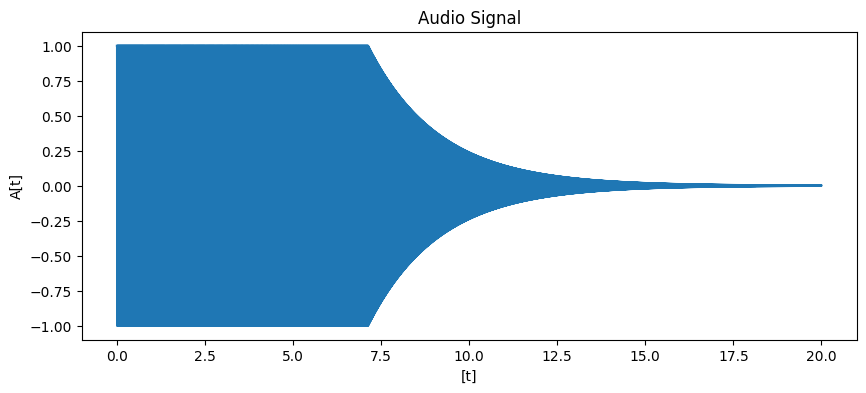

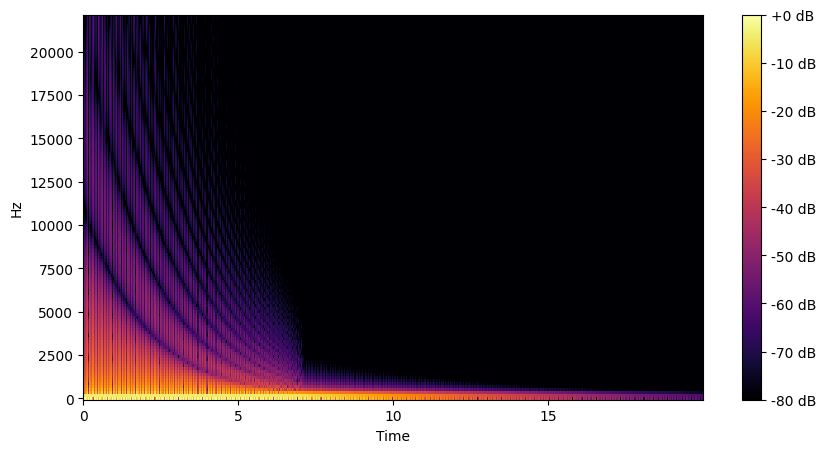

In [18]:
plotAudio(x, sr)
display_spectrogram(x = x, sample_rate = sr)

**b) Apply a quantization + dequantization process to the previous signal using 8 bits, and display the waveform, the spectrogram, and an audio player of the resulting signal.**

#### Applying Quantisation to Signal and plotting it

In [19]:
xQuantised = quantize(x = x, N = 4)
xDeQuantised = dequantize(xQuantised, N = 4)

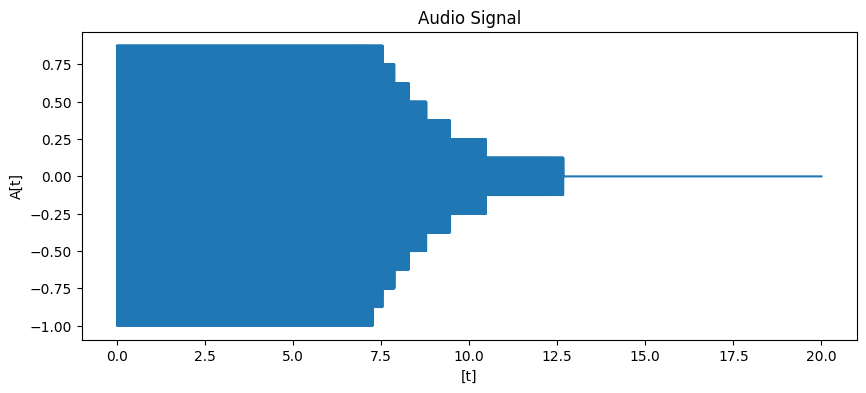

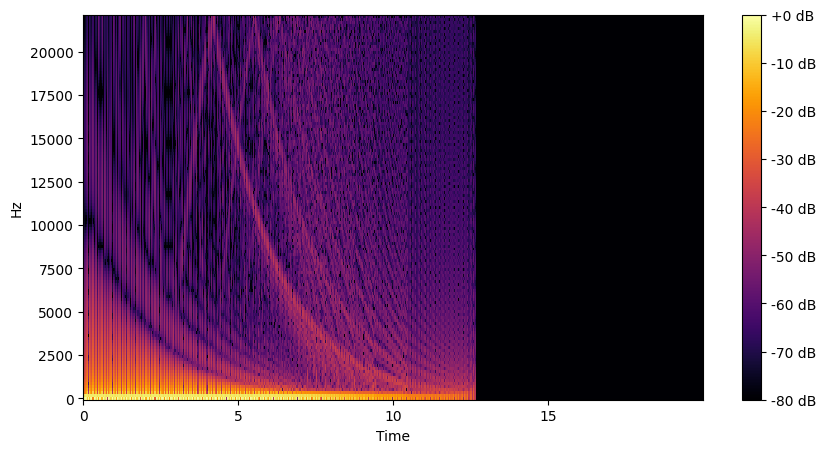

In [20]:
plotAudio(x = xDeQuantised, sr = sr)
display_spectrogram(xDeQuantised, sample_rate=sr)

In [21]:
Audio(data = x, rate = sr)

In [22]:
Audio(data = xDeQuantised, rate = sr)

**c) Include any observation you might find interesting about this analysis**

We can clearly see that the resolution of the original waveform has been severely compromised, since we now only have $2^4 = 16$ discrete steps to represent the original signal. In the process, we have also created some aliasing artefacts which can be seen in the spectrogram as sharp cascading curves and heard as a sort of saw wave when listening to the audio. Interestingly and not coincidentally, the decay after 12 seconds of audio in the dequantized audio file is coded and decoded as silence, where the original clearly hasn't fully decayed. This is why we typically want high resolution decoders for smaller amplitudes/energies.

# 2. Entropy calculation (20%)

## Exercise 2.1 (20%)
**a) Develop a function that allows you to plot the entropy of a source with variable output probabilities. We wish to observe that the maximum source entropy does indeed occur when the source outputs are equally likely.**

**The head of the function should be:**

```python
def calculate_entropy(probs):
    """
        Args:
            probs (np.array): Array of probs. for each symbol in the source
        Returns:
            (float) H (i.e. Entropy)
    """
```

**Please, take into account the cases where probabilities are 0.0, or incorrect inputs with negative probabilities (we can return `np.nan` in that case)**

First assert is the most important one:

```python
assert(calculate_entropy([0.5, 0.5]) == 1.0)
```

Complying with the rest of asserts is a bit harder:

```python
assert(calculate_entropy([1.0, 0.0]) == 0.0)
assert(np.isnan(calculate_entropy([-1.0, 0.0])))
assert(calculate_entropy([0.0, 1.0]) == 0.0)
```

So I consider the three last ones as optional (they just consider edge cases or incorrect inputs).

In [23]:
probs = [0.0, 1.0, 1.0]
probs = np.array(probs).astype(float)

In [24]:
def calculate_entropy(probs):
    """
        Args:
            probs (np.array): Array of probs. for each symbol in the source
        Returns:
            (float) H (i.e. Entropy)
    """
    probs = np.array(probs).astype(float)
    
    probs   = probs[probs != 0.0]    
    logVals = np.log2(probs)
    return -np.sum(probs * logVals)
    

In [25]:
assert(calculate_entropy([0.5, 0.5]) == 1.0)
assert(calculate_entropy([1.0, 0.0]) == 0.0)
assert(np.isnan(calculate_entropy([-1.0, 0.0])))
assert(calculate_entropy([0.0, 1.0]) == 0.0)

/var/folders/5c/3dr00pbn1gj6dgsr1wm3g2z40000gn/T/ipykernel_216/1248373869.py:11: RuntimeWarning: invalid value encountered in log2
  logVals = np.log2(probs)


**b) Consider a simple two-output source $[m_1, m_2]$ with respective probabilities $[a, 1 - a]$, and plot the entropy as a function of the parameter $a$, where $0 ≤ a ≤ 1$.**

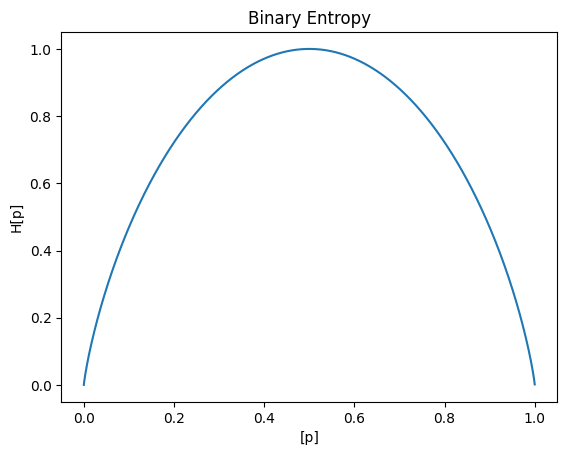

In [26]:
a = np.arange(0,1,0.0001)
y = [calculate_entropy([val, 1 - val]) for val in a]

plt.title("Binary Entropy")
plt.xlabel("[p]")
plt.ylabel("H[p]")
plt.plot(a, y);


**c) Optional: consider more complex cases such as a three output source $[m_1, m_2, m_3]$ with
respective probabilities $[a, b, 1 − a − b]$. Plot a 2D image with `plt.imshow` where entropy is displayed as a function of `a` and `b` parameters.**

# 3. Huffman Encoding (40%)

In this exercise, Huffman coding will be applied to compress `speech.wav` file.


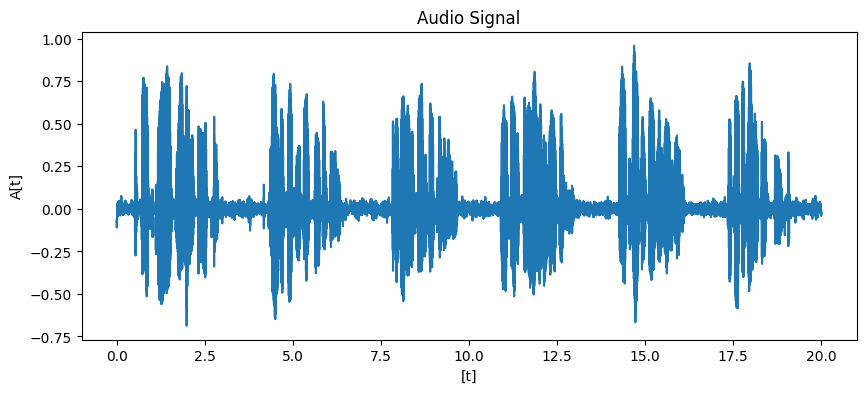

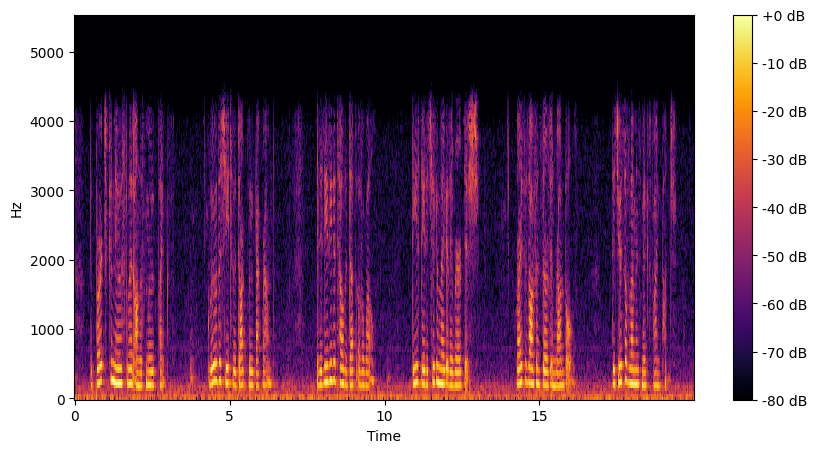

In [27]:
x, sr = librosa.load("speech.wav",
                     sr=11025, mono=True)
plotAudio(x, sr)
display_spectrogram(x)
display_audio_player(x)

## Exercise 3.1 (15%)

**a) Quantize signal `x` using 4 bits. Call it `y`**

Tip: The answer is:

```
bits_per_sample = 4
y = quantize(x, bits_per_sample)
```

Please, do not spend time dealing with it.

In [28]:
y = quantize(x = x, N = 4)

**b) Implement a function that computes the probability of occurrence per symbol for `y`.**

**The header of the function must be:**

Tip: With `np.unique(y, return_counts=True)`, the answer can be done with three lines. Beware that np.unique returns counts, instead of probabilities, so you have to normalize them (probabilities sum 1.0).

Remember that a function can return more than one element in python, e.g.

```python
def get_prob_per_symbol(y):
    """ Get symbol occurrence probability
    Args:
        x (np.array): Input signal
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probabilities)
    """
    # Complete function here
    return symbols, probs
symbols, probs = get_prob_per_symbol(y)
```

In [29]:
def get_prob_per_symbol(y):
    """ Get symbol occurrence probability
    Args:
        x (np.array): Input signal
    Returns:
        (np.array, np.array): (sorted symbols, corresponding probabilities)
    """
    # Complete function here
    symbols, count = np.unique(y, return_counts = True)
    tot = np.sum(count)
    probs = count / tot

    return symbols, probs

symbols, probs = get_prob_per_symbol(y)


**c) Use the implemented function to display the symbol probability distribution for `y`**

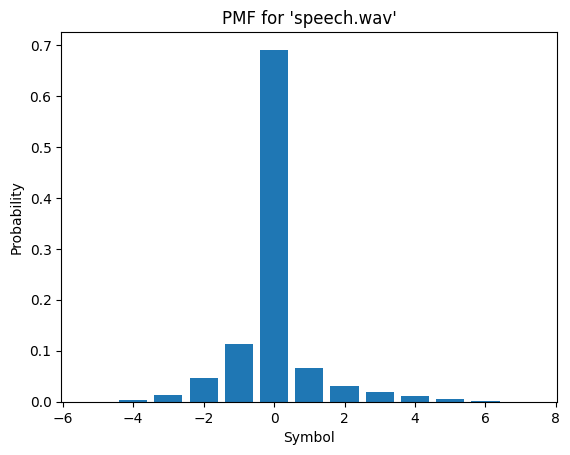

In [30]:
plt.title("PMF for 'speech.wav'")
plt.xlabel("Symbol")
plt.ylabel("Probability")
plt.bar(symbols, probs);

**d) Do you think this probability distribution will be similar in other speech signals?**

Yes, and in general for almost any audio signal centered at 0, since that is the DC value for all values which in turn is the expected value $E[x]$ of an audio signal $x$.

**e) Compute the entropy of `y`**

In [31]:
entropyY = calculate_entropy(probs = probs)
print(entropyY)

1.6889143835578557


## Exercise 3.2 (15%)

**a) Review the documentation of `huffman` python package:**

https://pypi.org/project/huffman/

**and generate a codebook for the previously computed symbols and probabilities.**

Given a list of symbols, and a list of probabilities, (as returned by get_prob_per_symbol)
the input to huffman.codebook(symbol_probs) must be:

```symbol_probs = [(s, p) for (s, p) in zip(symbols, probs)]```

It is the format huffman package understands.


In [32]:
import huffman

In [33]:
symbolProbs = [(s,p) for (s,p) in zip(symbols, probs)]
huffman.codebook(symbolProbs)

{-5: '000000001',
 -4: '0000001',
 -3: '01000',
 -2: '0101',
 -1: '011',
 0: '1',
 1: '001',
 2: '0001',
 3: '01001',
 4: '00001',
 5: '000001',
 6: '00000001',
 7: '000000000'}

**b) Consider the bit array `10010110001`: is the associated symbols sequence unique?**

Yes, since huffman codes are prefrix free and therefore always uniquely decodable. Huffman mappings are injective, hence the bit sequence above can be decoded as:
<br>
<br>
$[0, 1, -1, 2]$

**c) Compute:**
- **Code mean length**
- **Code efficiency**
- **Compression ratio**


In [34]:
myCodeBook = huffman.codebook(symbolProbs)

mean_length         = sum(prob * len(myCodeBook[symbol]) for symbol, prob in symbolProbs)
code_efficiency     = mean_length / entropyY
R                   = np.log2(len(symbols)) 
compression_ratio   = R / mean_length


In [35]:
print("Mean length: {0}".format(mean_length))
print("Code efficiency: {0:.2f}%".format(100 * code_efficiency))
print("Compression ratio: {0:.2f}%".format(100 * compression_ratio))

Mean length: 1.8196054421768708
Code efficiency: 107.74%
Compression ratio: 203.36%


## Exercise 3.3 (10%)

**a) Using `bitarray` python package, encode the signal into a sequence of bits (method `.encode()` of `bitarray` package) with the codebook previously generated.**

https://pypi.org/project/bitarray/

Update:
The answer is:

```
from bitarray import bitarray
codebook_bitarray = {}
for (k, v) in codebook.items():  # codebook as returned by huffman package
  codebook_bitarray[k] = bitarray(v)
a = bitarray()
a.encode(codebook_bitarray, y)
print(a)
```

Instead of implementing it from scratch, please explain what it does.

In [65]:
codebook = huffman.codebook(symbolProbs)

from bitarray import bitarray
codebook_bitarray = {}
for (k, v) in codebook.items():  # codebook as returned by huffman package
  codebook_bitarray[k] = bitarray(v)
a = bitarray()
a.encode(codebook_bitarray, y)
print(a)

bitarray('011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011011110110110110110110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

The code takes the previous codebook and the previous signal y and encodes it into a bitarray, i.e. a continuous sequence of bits where each quantised sample corresponds to its codeword.  

**b) Decode the signal using `.decode()` method of `bitarray` package, and verify it equals `y` for all samples.**

In [37]:
y_hat = bitarray.decode(a, codebook_bitarray)
bools = np.equal(y, y_hat)
np.all(bools)

True

**c) Compute the size in kilobits per second of the bit arrays before (i.e. fix-length) and after Huffman encoding.**

### Huffman 

$Bitrate [bps] = \frac{numBits}{duration}$
<br>
<br>
$Bitrate [kbps] = \frac{Bitrate [bps]}{1000}$

In [67]:
num_bits = len(a) 
duration = len(x) / sr

bitrate_bps             = num_bits / duration
kbps_per_second_encoded = bitrate_bps / 1000

print(kbps_per_second_encoded) 
print(num_bits)


20.06115
401223
220500


### Fixed Length

$Bitrate [kbps] = (\frac{BitDepth \cdot SampleRate \cdot NumChannels}{1000}) \cdot Duration [s]$

In [68]:
bitDepth    = 4
numChannels = 1

kbps_per_second_fixlength = (4 * sr) / 1000

In [69]:
print("kbps fixed-length: {0}kbps".format(kbps_per_second_fixlength))
print("kbps Huffman: {0}kbps".format(kbps_per_second_encoded))

kbps fixed-length: 44.1kbps
kbps Huffman: 20.06115kbps


**d) Are the previous kbps values consistent with the compression ratio already computed before?**

In [70]:
compressionRatio = kbps_per_second_fixlength / kbps_per_second_encoded
print(f"{np.round(compressionRatio * 100, 2)}%")

219.83%


The compression ratio isn't exactly the same, which is to be expected, since the previous theoretical value used the average code length of the code as a metric. However, we can still see that the compression ratio is roughly equal.